## Rotations

This part of the package is by far the most costly operation. It carries out of the following steps a large number of times

1. Rotates all data points
2. Discretize the rotated data
3. Estimate the transition matrix
4. Compute pathways

Unlike obtaining a bootstrap sample; in this case for each rotation every step of the algorithm has to be run making it very costly.

As this is a very good way to use the package; an example is given at the end to make the output into a dataframe for easy exportation.

### Making the networks
The below is the costly part, hence we use multiprocessing to speed it up. 

**NOTE** In this example the remove_undesired function is not run on the transition matrix network. We show the consequences of this later in the Artificial connections page.

In [1]:
import os
import pickle
import numpy as np
from multiprocessing import Pool

import driftmlp
from driftmlp.rotations import random_ll_rot
from driftmlp.drifter_indexing.discrete_system import h3_default

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


# Set seed for reproducibility
np.random.seed(1)
# Generate rotations before parallization
rotations = [random_ll_rot() for i in range(8)]  #
DFILE = os.environ['DRIFTFILE']


def get_network(rot):
    #Discretizers can be troublesome to pickle, 
    #so apply rotation directly using the lon_lat_transform kwarg
    #By specifing variables, we can read the data slightly quicker.
    drift_kwargs = {'variables': ['position', 'drogue', 'datetime'],
                    'drop_na': False,
                    'drogue': None, #drouge : None gives all drifters, True for drogued only, False for undrogued
                    'lon_lat_transform': rot} 

    net = driftmlp.driftfile_to_network(DFILE, drift_kwargs=drift_kwargs)
    return net
p = Pool(3)
networks = p.map(get_network, rotations)
p.close()
del p

discretizers = [h3_default(res=3, rot=rotation) for rotation in rotations]
plotting_dfs = [driftmlp.plotting.make_gpd.full_multipolygon_df(discretizer=discretizer) for discretizer in discretizers]

The below functions and locations are from the bootstrap notebook example

In [2]:
#Copy sample locations from basic_pathways page
from_loc = [-90.90, 23.88]
to_loc =[-9.88, 35.80] 
locs = {
    "Gulf of Mexico": from_loc,
    "Strait of Gibraltar": to_loc,
    "North Atlantic" : [-41, 34],
    "South Atlantic" : [-14, -27], 
    "North Pacific" : [-170, 30]
}
N_locs = len(locs)

def make_heatmap(arr, ax):
    ax.set_xticks(np.arange(N_locs))
    ax.set_yticks(np.arange(N_locs))
    # ... and label them with the respective list entries
    ax.set_xticklabels(locs.keys())
    ax.set_yticklabels(locs.keys())
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(N_locs):
        for j in range(N_locs):
            text = ax.text(j, i, np.round(arr[i, j]/365,2) ,
                           ha="center", va="center", color="w")

    

    ax.imshow(arr)


def extract_travel_time_matrix(list_of_lists):
    """
    Turn a list of lists of network paths into an array
    
    Prints a warning if there is an invalid path
    """
    tt = np.array([[path.travel_time for path in list_of_paths] for list_of_paths in list_of_lists])
    if np.any(tt<0):
        print("WARNING: There's an invalid path")
    return tt

### Obtaining pathways and traveltimes

Note this time each network was created with a different discretizer so we must use the correct discretizer for each network.

In [3]:
def rotation_pathways(network, discretizer):
    """
    Takes in network and the discretizer used to create the network.
    Outputs all pairwise network_path objects between the global dict locs.
    """
    h3_ids = discretizer.return_inds(locs.values())
    # Get all pathways
    return driftmlp.shortest_path.AllPairwisePaths(network, h3_ids)

paths = [rotation_pathways(T, discretizer) for T, discretizer in zip(networks, discretizers)]
travel_times_arr = np.stack([extract_travel_time_matrix(paths_list_of_lists) for paths_list_of_lists in paths])

#### Single origin, destination pair
 
The geopandas dataframe used for plotting the geometries also depend on the the discretizer so, a different one must be used for each transition matrix. Each of these were created at the top of this page. 

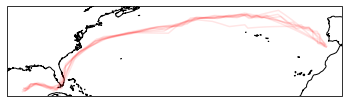

In [4]:
from driftmlp.plotting import h3_cartopy

def plot_od_pair(from_idx, to_idx, networks, plotting_dfs, paths):
    fig = plt.figure()
    ax = plt.subplot(projection = ccrs.PlateCarree())

    for i in range(len(networks)):
        # Plot bootstrapped lines with a bit of uncertainty
        pathway = paths[i][from_idx][to_idx]
        h3_cartopy.plot_line(plotting_dfs[i], pathway.h3id, ax=ax, alpha=0.1, color='red', centroid_col='centroid_col')
    ax.coastlines()
plot_od_pair(0,1,networks, plotting_dfs, paths)

The results for this particular pathway are very similar to the bootstrap. All pathways strongly agree up until the mid atlantic where pathways then find different ways to go.

#### Travel time matrix
Similar to the bootstrap example one can estimate the rotation mean and variance.

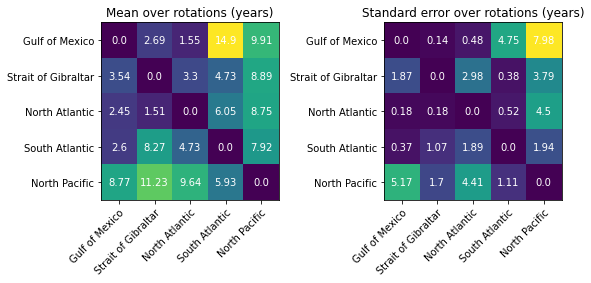

In [5]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
make_heatmap(travel_times_arr.mean(axis=0), ax=ax[0])
make_heatmap(travel_times_arr.std(axis=0, ddof=1), ax=ax[1])
ax[0].set_title("Mean over rotations (years)")
ax[1].set_title("Standard error over rotations (years)")
fig.tight_layout()

Strangely, a few of these pathways have massive standard errors, this is linked to not calling `driftmlp.helpers.remove_undesired` see the end of this page on Artificial connections

### Output
Quick example to turn the mean travel times into a pandas dataframe. .to_csv or a similar output pandas function to save the output

In [6]:
import pandas as pd
def matrix_to_pd(locs, arr):
    names = list(locs.keys())
    print(names)
    N = len(locs)
    origin = [name for _ in names for name in names]
    destination = [name for name in names for _ in names]
    mean_arr = arr.mean(axis=0)
    std_arr = arr.std(axis=0, ddof=1)
    mean_tt = [mean_arr[i,j] for j in range(N) for i in range(N)]
    std_tt = [std_arr[i,j] for j in range(N) for i in range(N)]
    
    out_df = pd.DataFrame({"origin": origin, "destination":destination, "mean_rotation": mean_tt, "std_tt": std_tt})
    out_df = out_df[out_df['mean_rotation']!=0].reset_index()
    return out_df
tt_df = matrix_to_pd(locs, travel_times_arr)
tt_df.head()

['Gulf of Mexico', 'Strait of Gibraltar', 'North Atlantic', 'South Atlantic', 'North Pacific']


,index,origin,destination,mean_rotation,std_tt
0,1,Strait of Gibraltar,Gulf of Mexico,1290.998772,682.847072
1,2,North Atlantic,Gulf of Mexico,892.437815,67.182663
2,3,South Atlantic,Gulf of Mexico,949.059533,136.494368
3,4,North Pacific,Gulf of Mexico,3201.075716,1886.685404
4,5,Gulf of Mexico,Strait of Gibraltar,981.287333,50.149818


## Artificial Connections

A side benefit of the rotation functionality is that is can highlight artificial connections. We seen a VERY high a standard error going from the North Pacific over to the Gulf of mexico for example. We can investigate this by plotting the pathways

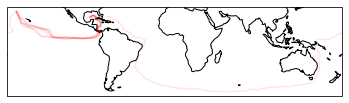

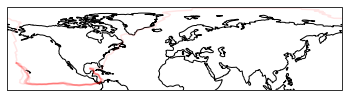

In [7]:
plot_od_pair(0,4,networks, plotting_dfs, paths)
plot_od_pair(4,0,networks, plotting_dfs, paths)

Both of these pathways on occasion just hopping over the Panama Isthmus; which has never been observed by a drifter and is actually just a result of the grid system used covering both sides. 

In the package there is functionallity to remove the connections over the Strait of Gibraltar and the Panama Isthumus using the `driftmlp.helpers.removed_undesired` function. It takes the points listed in the dictionary below, finds the discrete index and automatically deletes those states and corresponding transitions from the transition matrix. 

Note this also results in an invalid transition matrix; however this does not hugely affect the algorithm.

In [8]:
driftmlp.helpers.RM_DICT

{'panama': [[-79.69761240838052, 9.071323224898283],
  [-80.7277450395157, 8.661515581046203],
  [-80.62056, 8.62546],
  [-79.75539, 9.14105],
  [-78.27094, 9.04209],
  [-78.89288, 9.24109],
  [-79.39155, 9.25902],
  [-77.71613, 8.53722],
  [-81.32878, 8.39822],
  [-81.73527, 8.57208],
  [-82.33402, 8.71328],
  [-82.63083, 8.92083],
  [-83.69508, 9.77753],
  [-83.94228, 10.04808]],
 'straitofgibraltar': [[-5.5999, 35.9945],
  [-5.6149, 35.8804],
  [-5.51375, 36.03685],
  [-5.56489, 35.57513]]}

Now we run the function on all of the networks and observe how the results change

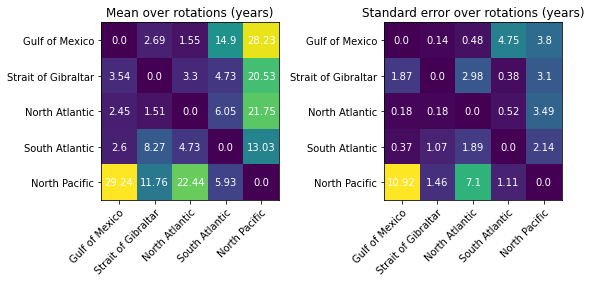

In [9]:
for i in range(len(networks)):
    driftmlp.helpers.remove_undesired(networks[i], discretizer=discretizers[i])
paths = [rotation_pathways(T, discretizer) for T, discretizer in zip(networks, discretizers)]
travel_times_arr = np.stack([extract_travel_time_matrix(paths_list_of_lists) for paths_list_of_lists in paths])

fig, ax = plt.subplots(1,2, figsize=(8,4))
make_heatmap(travel_times_arr.mean(axis=0), ax=ax[0])
make_heatmap(travel_times_arr.std(axis=0, ddof=1), ax=ax[1])
ax[0].set_title("Mean over rotations (years)")
ax[1].set_title("Standard error over rotations (years)")
fig.tight_layout()

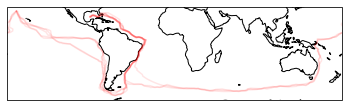

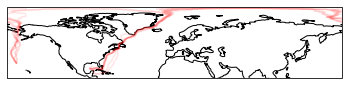

In [10]:
plot_od_pair(0,4,networks, plotting_dfs, paths)
plot_od_pair(4,0,networks, plotting_dfs, paths)

The standard errors seem slightly less un-usual. The North Pacific to Gulf of Mexico travel time standard error seems high, but when taken relative to the large travel time this seems more reasonable. Also the corresponding pathway does not cross any land masses.